## Generating Figures 

### This notebook will walk you through regenerating all five figures from the paper. 

First, import the necessary packages and custom functions. Make sure you provide the correct local path to the custom module ```simulation_data```.

Before running the code in this notebook, make sure to complete the steps in ```Data_Acquisition.ipynb``` and provide a valid **API Key** in ```simulation_data.__init__.py```.

In [2]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data

Load pre-calculated data from file: ```galaxy_population_data_2.hdf5``` for faster execution.

In [3]:
with h5py.File('galaxy_population_data_'+str(2)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
    halflight_radius_U = f['halflight_radius_U'][:]
    halflight_radius_V = f['halflight_radius_V'][:]
    halflight_radius_I = f['halflight_radius_I'][:]
    newbin_current_SFR = f['newbin_current_SFR'][:]
    maximum_merger_ratio_30kpc_current_fraction = f['maximum_merger_ratio_30kpc_current_fraction'][:]

Now apply the selection criteria for star-forming, young quiescent (post-starburst), intermediate, and old quiescent galaxies at $z=2$.

In [4]:
import warnings
warnings.filterwarnings('ignore')

PSB_selection = (median_age<=1.2)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
intermediate_quiescent_selection = (median_age>1.2)&(median_age<=1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
old_quiescent_selection = (median_age>1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
starforming_selection = (np.log10(newbin_current_SFR/10**(total_mass))>-10.5)

Load the ids of the main progenitors at $z=3$ and descendants at $z=1.5$ for each galaxy in the mass range at $z=2$.

In [5]:
with h5py.File('redshift_ids.hdf5', 'r') as f:
    z1_5_ids = f['z1.5_ids'][:]
    z3_ids = f['z3_ids'][:]
    print(f.keys())

<KeysViewHDF5 ['z1.5_ids', 'z2_ids', 'z3_ids']>


### Figure 1

Star formation histories for the four galaxy populations. For the star-forming population we only show 80 randomly drawn galaxies, for clarity.  The curves are binned over 100 Myr and normalized by the total mass formed.  In each panel a bold curve marks the median trend.

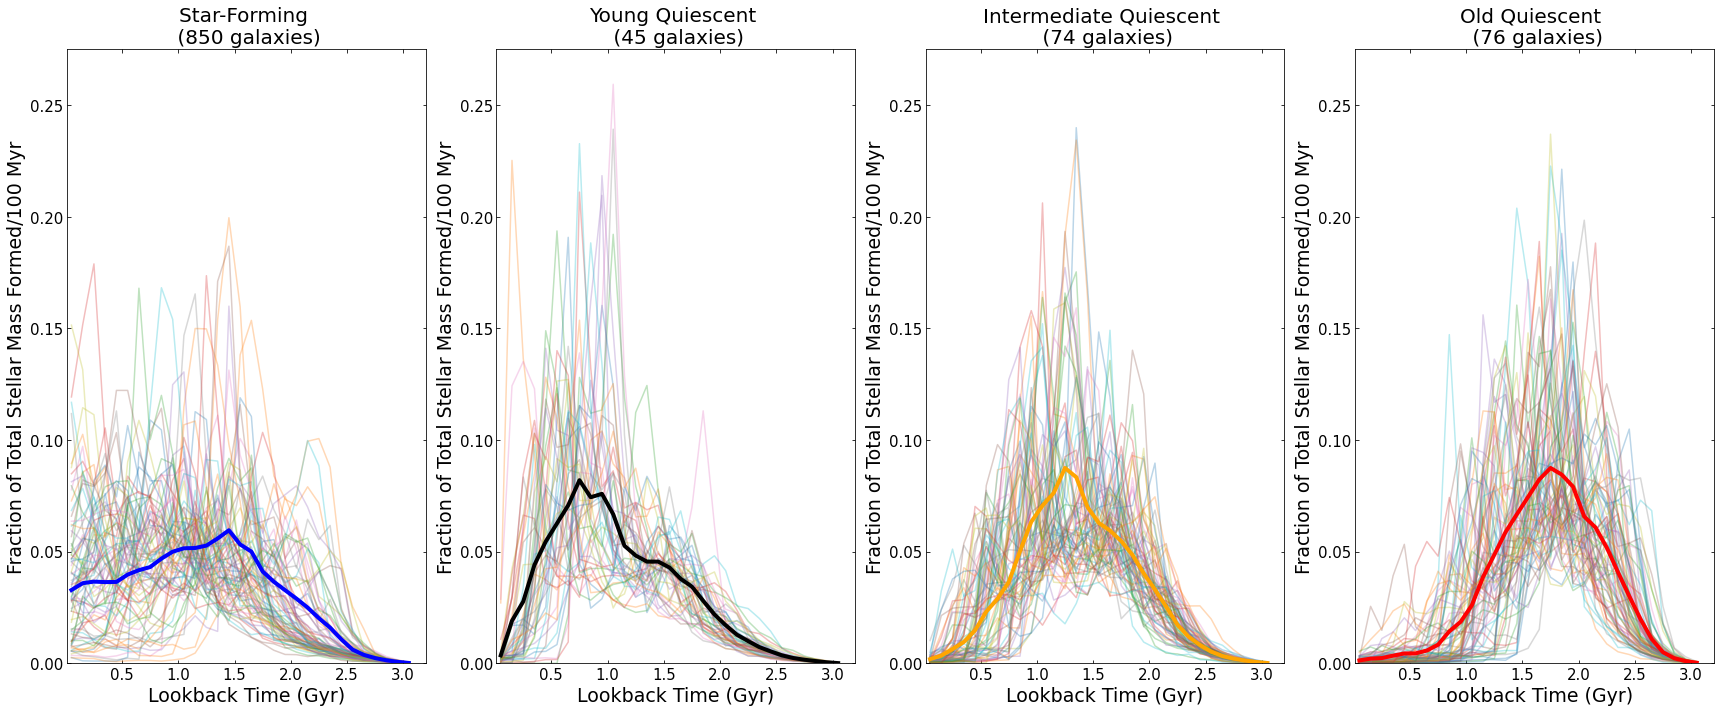

In [6]:
# SFH of all 4 galaxy classes
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='none', sharey='none', figsize=(24, 10))
f.set_facecolor('w')

redshift=2
binwidth=0.1 #Gyr

#panel 1: 80 star-forming galaxies
HistWeights = np.zeros(0)
LookbackTime = np.zeros(0)
np.random.seed(0)
for id in np.random.choice(ids[starforming_selection], 80, replace=False):
    id_SFH = get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[1]
    ax1.plot(get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[0], id_SFH/np.sum(id_SFH), alpha = 0.3)
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    HistWeights = np.concatenate((HistWeights, stellar_data['stellar_initial_masses']), axis = None) #units: logMsol/yr
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
SFH, BE = np.histogram(LookbackTime, bins=np.arange(0, max(LookbackTime), binwidth), weights=HistWeights, density = True)
bincenters = [(BE[i]+BE[i+1])/2. for i in range(len(BE)-1)]
ax1.plot(bincenters, SFH/np.sum(SFH), color = 'b', lw=4)
ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=20)
ax1.set_xlim(0.01, 3.2)
ax1.set_ylim(0, 0.275)
ax1.set_ylabel("Fraction of Total Stellar Mass Formed/100 Myr", fontsize=19)
ax1.set_xlabel("Lookback Time (Gyr)", fontsize=19)
ax1.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

#panel 2: young quiescent galaxies
HistWeights = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[PSB_selection]:
    id_SFH = get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[1]
    ax2.plot(get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[0], id_SFH/np.sum(id_SFH), alpha = 0.3)
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    HistWeights = np.concatenate((HistWeights, stellar_data['stellar_initial_masses']), axis = None) #units: logMsol/yr
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
SFH, BE = np.histogram(LookbackTime, bins=np.arange(0, max(LookbackTime), binwidth), weights=HistWeights, density = True)
bincenters = [(BE[i]+BE[i+1])/2. for i in range(len(BE)-1)]
ax2.plot(bincenters, SFH/np.sum(SFH), color = 'k', lw=4)
ax2.set_title('Young Quiescent \n ('+str(len(ids[PSB_selection]))+' galaxies)', fontsize=20)
ax2.set_xlim(0.01, 3.2)
ax2.set_ylim(0, 0.275)
ax2.set_ylabel("Fraction of Total Stellar Mass Formed/100 Myr", fontsize=19)
ax2.set_xlabel("Lookback Time (Gyr)", fontsize=19)
ax2.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

#panel 3: intermediate quiescent galaxies
HistWeights = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[intermediate_quiescent_selection]:
    id_SFH = get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[1]
    ax3.plot(get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[0], id_SFH/np.sum(id_SFH), alpha = 0.3)
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    HistWeights = np.concatenate((HistWeights, stellar_data['stellar_initial_masses']), axis = None) #units: logMsol/yr
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
SFH, BE = np.histogram(LookbackTime, bins=np.arange(0, max(LookbackTime), binwidth), weights=HistWeights, density = True)
bincenters = [(BE[i]+BE[i+1])/2. for i in range(len(BE)-1)]
ax3.plot(bincenters, SFH/np.sum(SFH), color = 'orange', lw=4)
ax3.set_title('Intermediate Quiescent \n ('+str(len(ids[intermediate_quiescent_selection]))+' galaxies)', fontsize=20)
ax3.set_xlim(0.01, 3.2)
ax3.set_ylim(0, 0.275)
ax3.set_xlabel("Lookback Time (Gyr)", fontsize=19)
ax3.set_ylabel("Fraction of Total Stellar Mass Formed/100 Myr", fontsize=19)
ax3.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

#panel 4: old quiescent galaxies
HistWeights = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[old_quiescent_selection]:
    id_SFH = get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[1]
    ax4.plot(get_star_formation_history(id=id, redshift=redshift, plot=False, binwidth=binwidth)[0], id_SFH/np.sum(id_SFH), alpha = 0.3)
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    HistWeights = np.concatenate((HistWeights, stellar_data['stellar_initial_masses']), axis = None) #units: logMsol/yr
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
SFH, BE = np.histogram(LookbackTime, bins=np.arange(0, max(LookbackTime), binwidth), weights=HistWeights, density = True)
bincenters = [(BE[i]+BE[i+1])/2. for i in range(len(BE)-1)]
ax4.plot(bincenters, SFH/np.sum(SFH), color = 'red', lw=4)
ax4.set_title('Old Quiescent \n ('+str(len(ids[old_quiescent_selection]))+' galaxies)', fontsize=20)
ax4.set_xlim(0.01, 3.2)
ax4.set_ylim(0, 0.275)
ax4.set_xlabel("Lookback Time (Gyr)", fontsize=19)
ax4.set_ylabel("Fraction of Total Stellar Mass Formed/100 Myr", fontsize=19)
ax4.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

f.tight_layout()
#f.show()
#Note that the sum of the histogram values will not be equal to 1 unless bins of unity width are chosen; 
#it is not a probability mass function.

### Figure 2

Effective size calculated in the rest-frame $U$ band, rest-frame $V$ band, and using the stellar mass distribution, as a function of total stellar mass. Galaxies are color-coded according to the populations defined in Section 2.2.  For the star-forming population we only show 80 randomly drawn galaxies; we also omit the intermediate quiescent population for clarity. Stars mark the median values for each population.

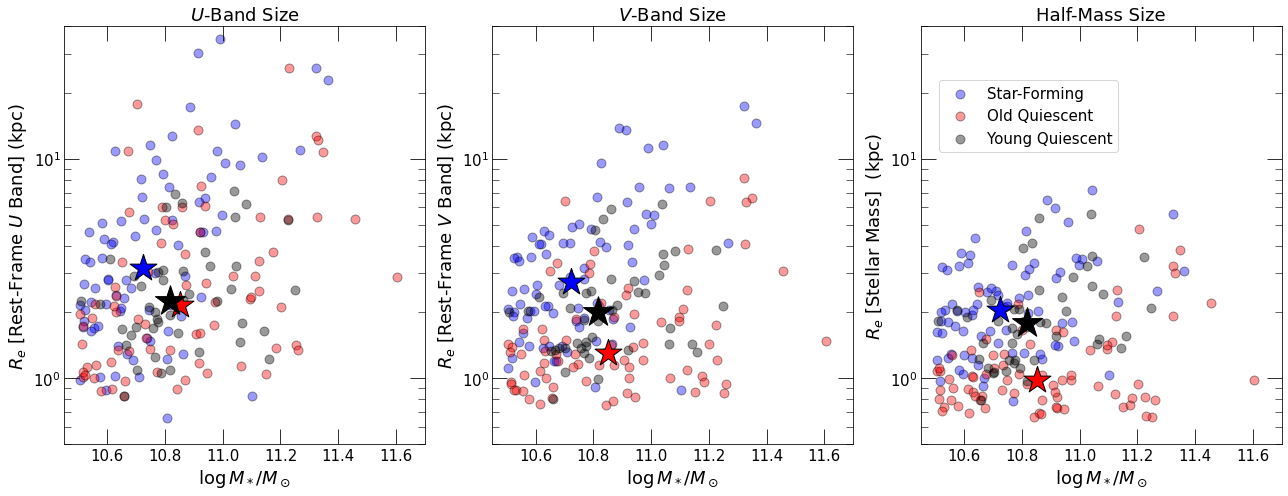

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(18, 7))
f.set_facecolor('w')

#data for seeded 80 random star-forming galaxies
np.random.seed(0)
rand_M = np.random.choice(total_mass[starforming_selection], 80, replace=False)
np.random.seed(0)
rand_U = np.random.choice(halflight_radius_U[starforming_selection], 80, replace=False)
np.random.seed(0)
rand_V = np.random.choice(halflight_radius_V[starforming_selection], 80, replace=False)
np.random.seed(0)
rand_m = np.random.choice(halfmass_radius[starforming_selection], 80, replace=False)

#panel 1: rest-frame U band half-light radii
ax1.scatter((rand_M), rand_U, c='blue', s=80, alpha=0.4, edgecolors='k', label='Star-Forming')
ax1.scatter((total_mass[old_quiescent_selection]), halflight_radius_U[old_quiescent_selection], c='red', s=80, alpha=0.4, edgecolors='k', label='Old Quiescent')
ax1.scatter((total_mass[PSB_selection]), halflight_radius_U[PSB_selection], c='k', s=80, alpha=0.4, edgecolors='k', label='Young Quiescent')
ax1.scatter(np.median(rand_M), np.median(rand_U), c='blue', edgecolors='k', s=800, marker='*', lw=1)
ax1.scatter(np.median(total_mass[old_quiescent_selection]), np.median(halflight_radius_U[old_quiescent_selection]), c='red', edgecolors='k', s=800, marker='*', lw=1)
ax1.scatter(np.median(total_mass[PSB_selection]), np.median(halflight_radius_U[PSB_selection]), c='black', s=1000, edgecolors='black', marker='*', lw=1)
ax1.set_ylim(0.5, 40)
ax1.set_xlim(10.45, 11.7)
ax1.set_xlabel('$\log \, M_*/M_\odot$', fontsize=18)
ax1.set_ylabel('$R_e$ [Rest-Frame $U$ Band] (kpc)', fontsize=18)
ax1.set_yscale('log')
ax1.set_title('$U$-Band Size', fontsize=18)
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=7)
ax1.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

#panel 2: rest-frame V band half-light radii
ax2.scatter((rand_M), rand_V, c='blue', s=80, alpha=0.4, edgecolors='k', label='Star-Forming Galaxies')
ax2.scatter((total_mass[old_quiescent_selection]), halflight_radius_V[old_quiescent_selection], c='red', s=80, alpha=0.4, edgecolors='k', label='Old Quiescent Galaxies')
ax2.scatter((total_mass[PSB_selection]), halflight_radius_V[PSB_selection], c='k', s=80, alpha=0.4, edgecolors='k', label='Young Quiescent Galaxies')
ax2.scatter(np.median(rand_M), np.median(rand_V), c='blue', edgecolors='k', s=800, marker='*', lw=1)
ax2.scatter(np.median(total_mass[old_quiescent_selection]), np.median(halflight_radius_V[old_quiescent_selection]), c='red', edgecolors='k', s=800, marker='*', lw=1)
ax2.scatter(np.median(total_mass[PSB_selection]), np.median(halflight_radius_V[PSB_selection]), c='black', s=1000, edgecolors='black', marker='*', lw=1)
ax2.set_ylim(0.5, 40)
ax2.set_xlim(10.45, 11.7)
ax2.set_xlabel('$\log \, M_*/M_\odot$', fontsize=18)
ax2.set_ylabel('$R_e$ [Rest-Frame $V$ Band] (kpc)', fontsize=18)
ax2.set_yscale('log')
ax2.set_title('$V$-Band Size', fontsize=18)
ax2.tick_params(which='major', length=15)
ax2.tick_params(which='minor', length=7)
ax2.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

#panel 3: half-mass radii
ax3.scatter((rand_M), rand_m, c='blue', s=80, alpha = 0.4, edgecolors='k', label='Star-Forming')
ax3.scatter((total_mass[old_quiescent_selection]), halfmass_radius[old_quiescent_selection], c='red', s=80, alpha = 0.4, edgecolors='k', label='Old Quiescent')
ax3.scatter((total_mass[PSB_selection]), halfmass_radius[PSB_selection], c='k', s=80, alpha=0.4, edgecolors='k', label='Young Quiescent')
ax3.scatter(np.median(rand_M), np.median(rand_m), c='blue', edgecolors='k', s=800, marker='*', lw=1)
ax3.scatter(np.median(total_mass[old_quiescent_selection]), np.median(halfmass_radius[old_quiescent_selection]), c='red', edgecolors='k', s=800, marker='*', lw=1)
ax3.scatter(np.median(total_mass[PSB_selection]), np.median(halfmass_radius[PSB_selection]), c='black', s=1000, edgecolors='black', marker='*', lw=1)
ax3.legend(loc=(0.05, 0.7), fontsize=15, frameon=True)
ax3.set_ylim(0.5, 40)
ax3.set_xlim(10.45, 11.7)
ax3.set_xlabel('$\log \, M_*/M_\odot$', fontsize=18)
ax3.set_ylabel('$R_e$ [Stellar Mass]  (kpc)', fontsize=18)
ax3.set_yscale('log')
ax3.set_title('Half-Mass Size', fontsize=18)
ax3.tick_params(which='major', length=15)
ax3.tick_params(which='minor', length=7)
ax3.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)

f.tight_layout()

### Figure 3

Radial age profiles for the four galaxy populations (thin lines). For the star-forming population we only show 50 randomly drawn galaxies, for clarity. The running median for each population is shown in thick unbroken lines. The median for the main progenitors at $z=3$ (thick dotted line) and the descendants at $z=1.5$ (thick dashed line) are also shown.

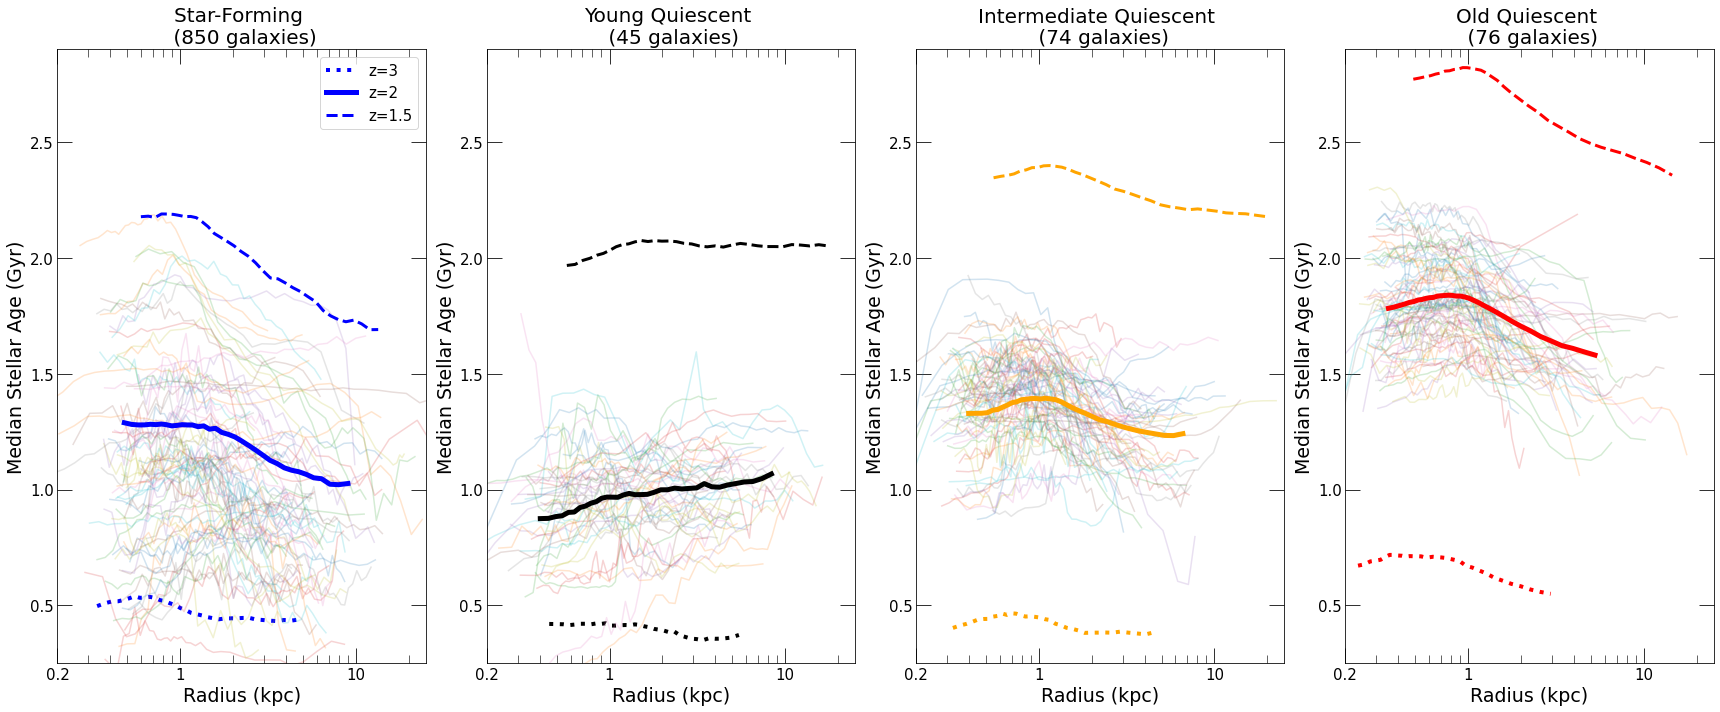

In [6]:
#age profiles
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='none', sharey='none', figsize=(24, 10))
f.set_facecolor('w')
n_bins=50

redshift=3
#z=3 progenitors of star-forming galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
np.random.seed(0)
for id in np.random.choice(z3_ids[starforming_selection], 80, replace=False):
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax1.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='blue', linewidth=4, linestyle='dotted', label='z=3')

#z=3 progenitors of young quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in z3_ids[PSB_selection]:
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax2.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='black', linewidth=4, linestyle='dotted', label='z=3')

#z=3 progenitprs of intermediate quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in z3_ids[intermediate_quiescent_selection]:
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax3.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='orange', linewidth=4, linestyle='dotted', label='z=3')

#z=3 progenitors of old quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in z3_ids[old_quiescent_selection]:
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax4.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='red', linewidth=4, linestyle='dotted', label='z=3')

redshift=2

#z=2 star-forming galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
np.random.seed(0)
for id in np.random.choice(ids[starforming_selection], 80, replace=False):
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    distance = np.concatenate((distance, R), axis = None)
    ax1.plot(age_profile(id=id, redshift=redshift, n_bins=n_bins)[1][5:-10], age_profile(id=id, redshift=redshift, n_bins=n_bins)[0][5:-10], alpha = 0.2)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax1.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='blue', linewidth=5, label='z=2')
ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=20) #
ax1.set_xlim(0.2, 25)
ax1.set_ylim(0.25, 2.9)
ax1.set_xlabel("Radius (kpc)", fontsize=19)
ax1.set_ylabel("Median Stellar Age (Gyr)", fontsize=19)
ax1.set_xscale('log')
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)
ax1.set_xticks([0.2, 1, 10], minor=False)
ax1.set_xticklabels(['0.2', '1', '10'])

#z=2 young quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[PSB_selection]:
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    distance = np.concatenate((distance, R), axis = None)
    ax2.plot(age_profile(id=id, redshift=redshift, n_bins=n_bins)[1][5:-10], age_profile(id=id, redshift=redshift, n_bins=n_bins)[0][5:-10], alpha = 0.2)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax2.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='black', linewidth=5)
ax2.set_title('Young Quiescent \n ('+str(len(ids[PSB_selection]))+' galaxies)', fontsize=20) #
ax2.set_xlim(0.2, 25)
ax2.set_ylim(0.25, 2.9)
ax2.set_xlabel("Radius (kpc)", fontsize=19)
ax2.set_ylabel("Median Stellar Age (Gyr)", fontsize=19)
ax2.set_xscale('log')
ax2.tick_params(which='major', length=15)
ax2.tick_params(which='minor', length=8)
ax2.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)
ax2.set_xticks([0.2, 1, 10], minor=False)
ax2.set_xticklabels(['0.2', '1', '10'])

#z=2 intermediate quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[intermediate_quiescent_selection]:
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    distance = np.concatenate((distance, R), axis = None)
    ax3.plot(age_profile(id=id, redshift=redshift, n_bins=n_bins)[1][5:-10], age_profile(id=id, redshift=redshift, n_bins=n_bins)[0][5:-10], alpha = 0.2)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax3.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='orange', linewidth=5)
ax3.set_title('Intermediate Quiescent \n ('+str(len(ids[intermediate_quiescent_selection]))+' galaxies)', fontsize=20) #
ax3.set_xlim(0.2, 25)
ax3.set_ylim(0.25, 2.9)
ax3.set_xlabel("Radius (kpc)", fontsize=19)
ax3.set_ylabel("Median Stellar Age (Gyr)", fontsize=19)
ax3.set_xscale('log')
ax3.tick_params(which='major', length=15)
ax3.tick_params(which='minor', length=8)
ax3.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)
ax3.set_xticks([0.2, 1, 10], minor=False)
ax3.set_xticklabels(['0.2', '1', '10'])

#z=2 old quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[old_quiescent_selection]:
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    distance = np.concatenate((distance, R), axis = None)
    ax4.plot(age_profile(id=id, redshift=redshift, n_bins=n_bins)[1][5:-10], age_profile(id=id, redshift=redshift, n_bins=n_bins)[0][5:-10], alpha = 0.2)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax4.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='red', linewidth=5)
ax4.set_title('Old Quiescent \n ('+str(len(ids[old_quiescent_selection]))+' galaxies)', fontsize=20) #
ax4.set_xlim(0.2, 25)
ax4.set_ylim(0.25, 2.9)
ax4.set_xlabel("Radius (kpc)", fontsize=19)
ax4.set_ylabel("Median Stellar Age (Gyr)", fontsize=19)
ax4.set_xscale('log')
ax4.tick_params(which='major', length=15)
ax4.tick_params(which='minor', length=8)
ax4.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)
ax4.set_xticks([0.2, 1, 10], minor=False)
ax4.set_xticklabels(['0.2', '1', '10'])


redshift=1.5

#z=1.5 descendents of z=2 star-forming galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
np.random.seed(0)
for id in np.random.choice(z1_5_ids[starforming_selection], 80, replace=False):
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax1.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='blue', linewidth=3, linestyle='--', label='z=1.5')
ax1.legend(loc='upper right', fontsize=15, frameon=True)

#z=1.5 descendents of z=2 young quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in z1_5_ids[PSB_selection]:
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax2.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='black', linewidth=3, linestyle='--', label='z=1.5')

#z=1.5 descendents of z=2 intermediate quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in z1_5_ids[intermediate_quiescent_selection]:
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax3.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='orange', linewidth=3, linestyle='--', label='z=1.5')

#z=1.5 descendents of z=2 old quiescent galaxies
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in z1_5_ids[old_quiescent_selection]:
    if id != -1:
        stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
        LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
        dx = stellar_data['relative_x_coordinates']
        dy = stellar_data['relative_y_coordinates']
        dz = stellar_data['relative_z_coordinates']
        R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
        distance = np.concatenate((distance, R), axis = None)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax4.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='red', linewidth=3, linestyle='--', label='z=1.5')

f.tight_layout()
#f.show()

### Figure 4

The age profiles of young quiescent galaxies, with separate panels for galaxies with at least one significant merger that contributes at least $10\%$ of the $z=2$ stellar mass (with mergers: left panel) and those without such a merger (right panel).

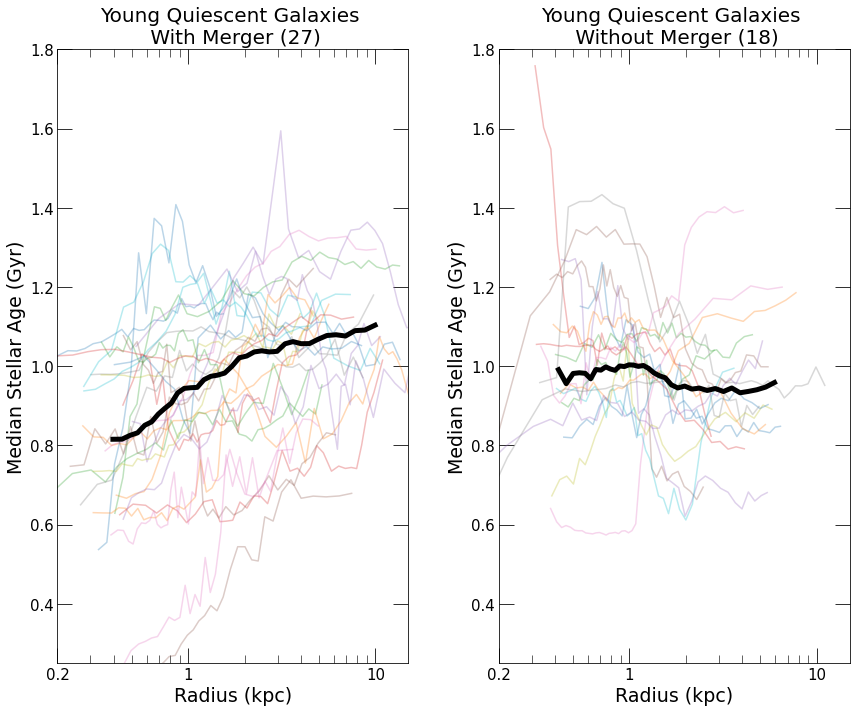

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(12, 10))
f.set_facecolor('w')
n_bins=50
redshift=2

#select young quiescent galaxies by merger cut-off
# had a significant prior merger 
PSB = (maximum_merger_ratio_30kpc_current_fraction>=0.1) & PSB_selection 
# had no significant prior merger
PSBm = (maximum_merger_ratio_30kpc_current_fraction<0.1) & PSB_selection 

#panel 1: young quiescent galaxies with mergers
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[PSB]:
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None)
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    distance = np.concatenate((distance, R), axis = None)
    ax1.plot(age_profile(id=id, redshift=redshift, n_bins=n_bins)[1][5:-10], age_profile(id=id, redshift=redshift, n_bins=n_bins)[0][5:-10], alpha = 0.3)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax1.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='black', linewidth=5)
ax1.set_title('Young Quiescent Galaxies \n With Merger ('+str(len(ids[PSB]))+')', fontsize=20) #
ax1.set_xlim(0.2, 15)
ax1.set_ylim(0.25, 1.8)
ax1.set_xlabel("Radius (kpc)", fontsize=19)
ax1.set_ylabel("Median Stellar Age (Gyr)", fontsize=19)
ax1.set_xscale('log')
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)
ax1.set_xticks([0.2, 1, 10], minor=False)
ax1.set_xticklabels(['0.2', '1', '10'])

#panel 2: young quiescent galaxies without mergers
distance = np.zeros(0)
LookbackTime = np.zeros(0)
for id in ids[PSBm]:
    stellar_data = get_galaxy_particle_data(id=id , redshift=redshift, populate_dict=True)
    LookbackTime = np.concatenate((LookbackTime, stellar_data['LookbackTime']), axis = None) 
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    distance = np.concatenate((distance, R), axis = None)
    ax2.plot(age_profile(id=id, redshift=redshift, n_bins=n_bins)[1][5:-10], age_profile(id=id, redshift=redshift, n_bins=n_bins)[0][5:-10], alpha = 0.3)
radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(distance, (100/n_bins)*i) 
statistic, bin_edges, bin_number = scipy.stats.binned_statistic(distance, LookbackTime, 'median', bins=radial_percentiles)
ax2.plot(np.array(radial_percentiles[1:])[5:-10], np.array(statistic)[5:-10], c='black', linewidth=5)
ax2.set_title('Young Quiescent Galaxies \n Without Merger ('+str(len(ids[PSBm]))+')', fontsize=20) #
ax2.set_xlim(0.2, 15)
ax2.set_ylim(0.25, 1.8)
ax2.set_xlabel("Radius (kpc)", fontsize=19)
ax2.set_ylabel("Median Stellar Age (Gyr)", fontsize=19)
ax2.set_xscale('log')
ax2.tick_params(which='major', length=15)
ax2.tick_params(which='minor', length=8)
ax2.tick_params(direction='in', which='both', labelsize=15, bottom=True, top=True, left=True, right=True)
ax2.set_xticks([0.2, 1, 10], minor=False)
ax2.set_xticklabels(['0.2', '1', '10'])

f.tight_layout(w_pad=4, h_pad=10)

### Figure 5

Stacked normalized histograms showing the radial distribution of stellar ages in each galaxy population. All stellar particles of all galaxies in a given population are split into five age bins; the colored bands show the fractional contribution of each bin to the total stellar mass, as a function of radius. Galaxies are divided according to whether they experienced (bottom panels) or did not experience (top panels) a significant merger prior to $z=2$. The number of galaxies in each category are indicated in brackets.

[Text(0, 0, '1'), Text(0, 0, '10')]

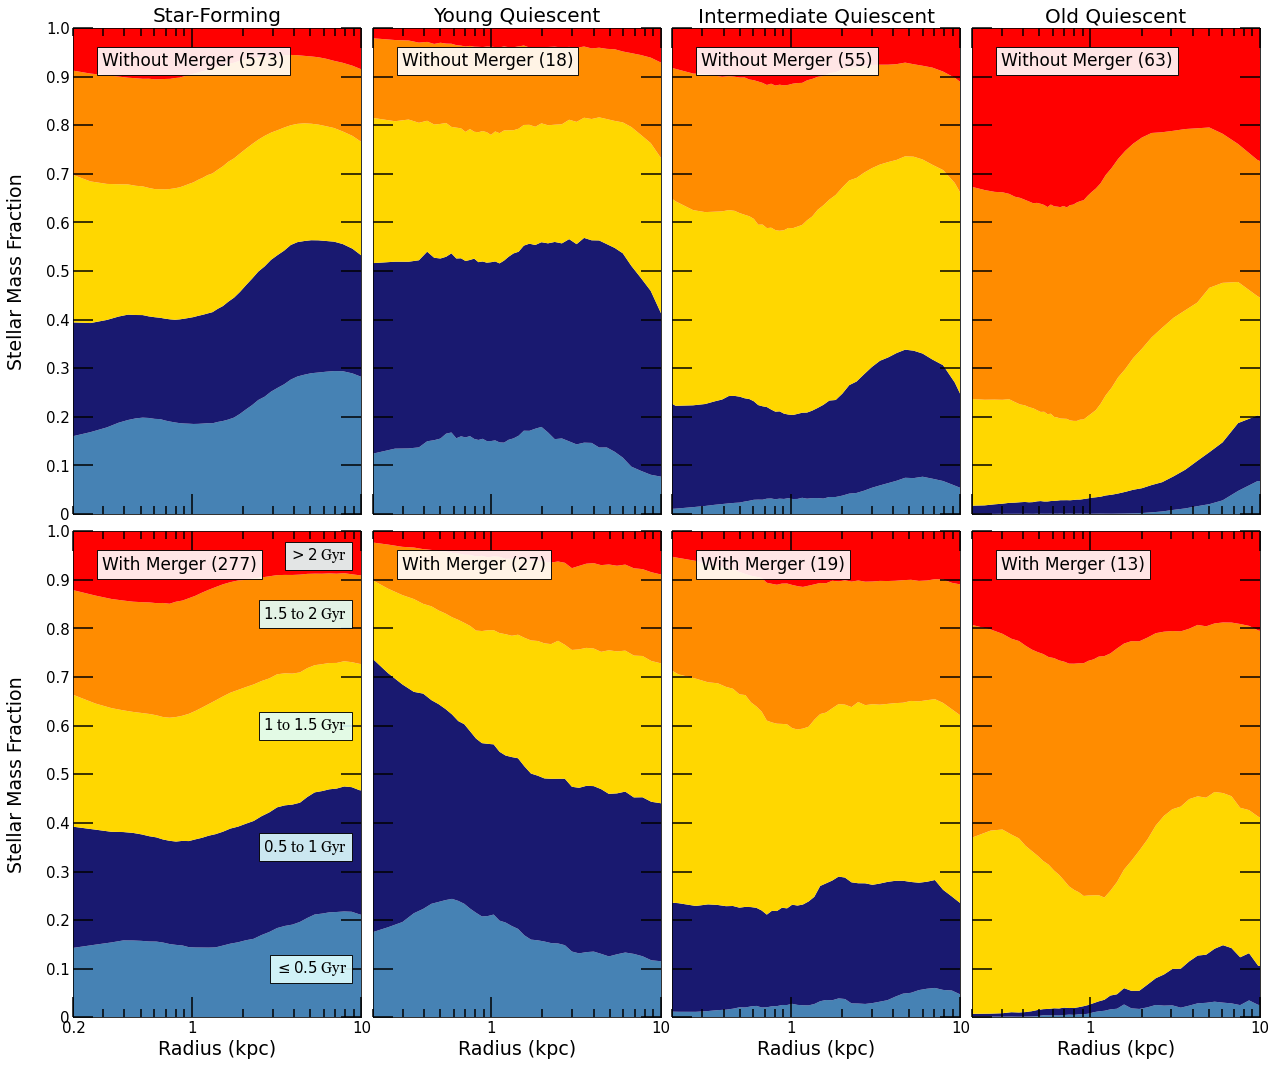

In [6]:
left = 0.05
bottom = 0.05
width = 0.20
height = 0.45
spacing = 0.008

f = plt.figure(figsize=(20, 15))
f.set_facecolor('white')
n_bins=50

props_pos = dict(boxstyle='square', facecolor='white', edgecolor='black', alpha=0.9)
props_leg = dict(boxstyle='square', facecolor='lightcyan', edgecolor='black', alpha=0.9)
#======================================================MAKE AXES==============================================================
# bottom row
ax1bottom = plt.axes([left, bottom, width, height])
ax2bottom = plt.axes([left+width+spacing, bottom, width, height])
ax3bottom = plt.axes([left+2*width+2*spacing, bottom, width, height])
ax4bottom = plt.axes([left+3*width+3*spacing, bottom, width, height])

# top row
ax1top = plt.axes([left, bottom+height+2*spacing, width, height])
ax2top = plt.axes([left+width+spacing, bottom+height+2*spacing, width, height])
ax3top = plt.axes([left+2*width+2*spacing, bottom+height+2*spacing, width, height])
ax4top = plt.axes([left+3*width+3*spacing, bottom+height+2*spacing, width, height])

#=====================================================SELECTION===============================================================

SFG = (maximum_merger_ratio_30kpc_current_fraction>=0.1) & starforming_selection
PSB = (maximum_merger_ratio_30kpc_current_fraction>=0.1) & PSB_selection
IQG = (maximum_merger_ratio_30kpc_current_fraction>=0.1) & intermediate_quiescent_selection
OQG = (maximum_merger_ratio_30kpc_current_fraction>=0.1) & old_quiescent_selection

SFGm = (maximum_merger_ratio_30kpc_current_fraction<0.1) & starforming_selection
PSBm = (maximum_merger_ratio_30kpc_current_fraction<0.1) & PSB_selection
IQGm = (maximum_merger_ratio_30kpc_current_fraction<0.1) & intermediate_quiescent_selection
OQGm = (maximum_merger_ratio_30kpc_current_fraction<0.1) & old_quiescent_selection

#====================================================PLOT SFG=================================================================
concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[SFGm]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)

ax1top.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax1top.set_title('Star-Forming', fontsize=20)
ax1top.set_ylabel("Stellar Mass Fraction", color='black', labelpad=20, fontsize=19)
ax1top.text(0.1, 0.95, 'Without Merger ('+str(len(ids[SFGm]))+')', transform=ax1top.transAxes, fontsize=17,
         va='top', ha='left', bbox=props_pos, color='black')
ax1top.set_xlim(0.2, 10)
ax1top.set_ylim(0, 0.40)
ax1top.tick_params(which='major', length=20)
ax1top.tick_params(which='minor', length=8)
ax1top.set_xticks([0.2, 1, 10], minor=False)
# ax1top.set_xticklabels(['0.2', '1', '10'])
ax1top.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax1top.set_yticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
ax1top.tick_params(direction='in', which='both', labelsize=15, labelleft=True, labelright=False, labelbottom=False, width=1.5, bottom=True, top=True, left=True, right=True)
ax1top.set_xscale('log')

#============================================================================================================================================

concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)


for idx in ids[SFG]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)

ax1bottom.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax1bottom.set_xlim(0.2, 10)
ax1bottom.set_ylim(0, 1)
ax1bottom.set_xscale('log')
ax1bottom.text(0.1, 0.95, 'With Merger ('+str(len(ids[SFG]))+')', transform=ax1bottom.transAxes, fontsize=17,
         va='top', ha='left', bbox=props_pos, color='black')
ax1bottom.set_ylabel("Stellar Mass Fraction", color='black', labelpad=20, fontsize=19)
ax1bottom.set_xlabel("Radius (kpc)", fontsize=19)
ax1bottom.tick_params(direction='in', which='both', labelsize=15, labelleft=True, labelbottom=True, labelright=False, width=1.5, bottom=True, top=True, left=True, right=True)
ax1bottom.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax1bottom.set_yticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
ax1bottom.tick_params(which='major', length=20)
ax1bottom.tick_params(which='minor', length=8)
ax1bottom.set_xticks([0.2, 1, 10], minor=False)
ax1bottom.set_xticklabels(['0.2', '1', '10'])

ax1bottom.text(0.95, 0.95, '$> 2$ Gyr', alpha=1, transform=ax1bottom.transAxes, fontsize=15, va='center', ha="right", bbox=props_leg, fontname="Georgia", color='black')
ax1bottom.text(0.95, 0.83, '$1.5 $ to $2$ Gyr', alpha=1, transform=ax1bottom.transAxes, fontsize=15, va='center', ha="right", bbox=props_leg, fontname="Georgia", color='black')
ax1bottom.text(0.95, 0.60, '$1 $ to $1.5$ Gyr', alpha=1, transform=ax1bottom.transAxes, fontsize=15, va='center', ha="right", bbox=props_leg, fontname="Georgia", color='black')
ax1bottom.text(0.95, 0.35, '$0.5 $ to $1$ Gyr', alpha=1, transform=ax1bottom.transAxes, fontsize=15, va='center', ha="right", bbox=props_leg, fontname="Georgia", color='black')
ax1bottom.text(0.95, 0.10, '$\leq 0.5$ Gyr', alpha=1, transform=ax1bottom.transAxes, fontsize=15, va='center', ha="right", bbox=props_leg, fontname="Georgia", color='black')
#----------------------------------------------------------------------------------------------------------------------------#
#====================================================PLOT PSB=================================================================
concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[PSBm]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)

ax2top.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax2top.set_title('Young Quiescent', fontsize=20)
ax2top.text(0.1, 0.95, 'Without Merger ('+str(len(ids[PSBm]))+')', transform=ax2top.transAxes, fontsize=17,
          va='top', ha='left', bbox=props_pos, color='black')
ax2top.set_xlim(0.2, 10)
ax2top.set_ylim(0, 0.40)
ax2top.set_xscale('log')
ax2top.tick_params(which='major', length=20)
ax2top.tick_params(which='minor', length=8)
ax2top.set_xticks([0.2, 1, 10], minor=False)
ax2top.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax2top.set_yticklabels([])
ax2top.tick_params(direction='in', which='both', labelsize=15, labelleft=False, labelright=False, labelbottom=False, width=1.5, bottom=True, top=True, left=True, right=True)

#============================================================================================================================================

concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[PSB]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)

ax2bottom.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax2bottom.set_xlim(0.2, 10)
ax2bottom.set_ylim(0, 1)
ax2bottom.text(0.1, 0.95, 'With Merger ('+str(len(ids[PSB]))+')', transform=ax2bottom.transAxes, fontsize=17,
         va='top', ha='left', bbox=props_pos, color='black')
ax2bottom.set_xlabel("Radius (kpc)", fontsize=19)
ax2bottom.tick_params(direction='in', which='both', labelsize=15, labelbottom=True, labelleft=False, labelright=False, width=1.5, bottom=True, top=True, left=True, right=True)
ax2bottom.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax2bottom.set_yticklabels([])
ax2bottom.set_xscale('log')
ax2bottom.tick_params(which='major', length=20)
ax2bottom.tick_params(which='minor', length=8)
ax2bottom.set_xticks([1, 10], minor=False)
ax2bottom.set_xticklabels(['1', '10'])

#----------------------------------------------------------------------------------------------------------------------------#

#====================================================PLOT IQG=================================================================
concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[IQGm]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)

ax3top.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax3top.set_title('Intermediate Quiescent', fontsize=20)
ax3top.text(0.1, 0.95, 'Without Merger ('+str(len(ids[IQGm]))+')', transform=ax3top.transAxes, fontsize=17,
         va='top', ha='left', bbox=props_pos, color='black')
ax3top.set_xlim(0.2, 10)
ax3top.set_ylim(0, 0.40)
ax3top.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax3top.set_yticklabels([])
ax3top.tick_params(direction='in', which='both', labelsize=15, labelleft=False, labelright=False, labelbottom=False, width=1.5, bottom=True, top=True, left=True, right=True)
ax3top.set_xscale('log')
ax3top.tick_params(which='major', length=20)
ax3top.tick_params(which='minor', length=8)
ax3top.set_xticks([0.2, 1, 10], minor=False)
#============================================================================================================================================

concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[IQG]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)
ax3bottom.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax3bottom.set_xlim(0.2, 10)
ax3bottom.set_ylim(0, 1)
ax3bottom.text(0.1, 0.95, 'With Merger ('+str(len(ids[IQG]))+')', transform=ax3bottom.transAxes, fontsize=17,
         va='top', ha='left', bbox=props_pos, color='black')
ax3bottom.set_xlabel("Radius (kpc)", fontsize=19)
ax3bottom.tick_params(direction='in', which='both', labelsize=15, labelbottom=True, labelleft=False, labelright=False, width=1.5, bottom=True, top=True, left=True, right=True)
ax3bottom.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax3bottom.set_yticklabels([])
ax3bottom.set_xscale('log')
ax3bottom.tick_params(which='major', length=20)
ax3bottom.tick_params(which='minor', length=8)
ax3bottom.set_xticks([1, 10], minor=False)
ax3bottom.set_xticklabels(['1', '10'])

#----------------------------------------------------------------------------------------------------------------------------#

#====================================================PLOT OQG=================================================================
concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[OQGm]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)
ax4top.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax4top.set_title('Old Quiescent', fontsize=20)
ax4top.text(0.1, 0.95, 'Without Merger ('+str(len(ids[OQGm]))+')', transform=ax4top.transAxes, fontsize=17,
          va='top', ha='left', bbox=props_pos, color='black')
ax4top.set_xlim(0.2, 10)
ax4top.set_ylim(0, 0.40)
ax4top.set_xscale('log')
ax4top.tick_params(which='major', length=20)
ax4top.tick_params(which='minor', length=8)
ax4top.set_xticks([0.2, 1, 10], minor=False)
ax4top.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax4top.set_yticklabels([])
ax4top.tick_params(direction='in', which='both', labelsize=15, labelleft=False, labelright=False, labelbottom=False, width=1.5, bottom=True, top=True, left=True, right=True)
handles, labels = ax4top.get_legend_handles_labels()


#============================================================================================================================================

concat_R_01_0 = np.zeros(0)
concat_R_01_1 = np.zeros(0)
concat_R_12_0 = np.zeros(0)
concat_R_12_1 = np.zeros(0)
concat_R_23 = np.zeros(0)

concat_M_01_0 = np.zeros(0)
concat_M_01_1 = np.zeros(0)
concat_M_12_0 = np.zeros(0)
concat_M_12_1 = np.zeros(0)
concat_M_23 = np.zeros(0)
mass_sum = np.zeros(0)
radx_sum = np.zeros(0)
age = np.zeros(0)

for idx in ids[OQG]:
    stellar_data = get_galaxy_particle_data(id=idx, redshift=2, populate_dict=True)
    
    LookbackTime = stellar_data['LookbackTime']
    M = stellar_data['stellar_masses']
    dx = stellar_data['relative_x_coordinates']
    dy = stellar_data['relative_y_coordinates']
    dz = stellar_data['relative_z_coordinates']
    R = (dx**2 + dy**2 + dz**2)**(1/2)#units: physical kpc
    
    concat_R_01_0 = np.concatenate((concat_R_01_0, R[LookbackTime<=0.5]), axis = None)
    concat_R_01_1 = np.concatenate((concat_R_01_1, R[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_R_12_0 = np.concatenate((concat_R_12_0, R[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_R_12_1 = np.concatenate((concat_R_12_1, R[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_R_23 = np.concatenate((concat_R_23, R[(LookbackTime>2)]), axis = None)
    
    concat_M_01_0 = np.concatenate((concat_M_01_0, M[LookbackTime<=0.5]), axis = None)
    concat_M_01_1 = np.concatenate((concat_M_01_1, M[(LookbackTime<=1)&(LookbackTime>0.5)]), axis = None)
    concat_M_12_0 = np.concatenate((concat_M_12_0, M[(LookbackTime<=1.5)&(LookbackTime>1)]), axis = None)
    concat_M_12_1 = np.concatenate((concat_M_12_1, M[(LookbackTime<=2)&(LookbackTime>1.5)]), axis = None)
    concat_M_23 = np.concatenate((concat_M_23, M[(LookbackTime>2)]), axis = None)
    
    age = np.concatenate((age, LookbackTime), axis = None)
    radx_sum = np.concatenate((radx_sum, R), axis = None)
    mass_sum = np.concatenate((mass_sum, M), axis = None)
    
radial_percentiles = np.zeros(n_bins + 1)
for i in range(1, (n_bins+1)):
    radial_percentiles[i] = np.percentile(radx_sum, (100/n_bins)*i) 
SFH_01_0, BE = np.histogram(concat_R_01_0, bins = radial_percentiles, weights=concat_M_01_0)
SFH_01_1, BE = np.histogram(concat_R_01_1, bins = radial_percentiles, weights=concat_M_01_1)
SFH_12_0, BE = np.histogram(concat_R_12_0, bins = radial_percentiles, weights=concat_M_12_0)
SFH_12_1, BE = np.histogram(concat_R_12_1, bins = radial_percentiles, weights=concat_M_12_1)
SFH_23, BE = np.histogram(concat_R_23, bins = radial_percentiles, weights=concat_M_23)
SFH, BE = np.histogram(radx_sum, bins = radial_percentiles, weights=mass_sum)

ax4bottom.stackplot(BE[:-1], SFH_01_0/SFH, SFH_01_1/SFH, SFH_12_0/SFH, SFH_12_1/SFH, SFH_23/SFH, 
              labels=['Age $\leq 0.5$', '$0.5 <$ Age $\leq 1$', '$1 <$ Age $\leq 1.5$', '$1.5 <$ Age $\leq 2$', 'Age $> 2$'], 
              colors=['steelblue', 'midnightblue', 'gold', 'darkorange', 'red'], alpha=1)
ax4bottom.set_xlim(0.2, 10)
ax4bottom.set_ylim(0, 1)
ax4bottom.text(0.1, 0.95, 'With Merger ('+str(len(ids[OQG]))+')', transform=ax4bottom.transAxes, fontsize=17,
         va='top', ha='left', bbox=props_pos, color='black')
ax4bottom.set_xlabel("Radius (kpc)", fontsize=19)
ax4bottom.tick_params(direction='in', which='both', labelsize=15, labelright=False, labelbottom=True, labelleft=False, width=1.5, bottom=True, top=True, left=True, right=True)
ax4bottom.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], minor=False)
ax4bottom.set_yticklabels([])
ax4bottom.set_xscale('log')
ax4bottom.tick_params(which='major', length=20)
ax4bottom.tick_params(which='minor', length=8)
ax4bottom.set_xticks([1, 10], minor=False)
ax4bottom.set_xticklabels(['1', '10'])


#----------------------------------------------------------------------------------------------------------------------------#